# Decision Trees

### Load modules

In [1]:
import pydotplus
import numpy as np
import pandas as pd
from sklearn.tree import _tree
from IPython.display import Image 
from sklearn.pipeline import Pipeline
#from sklearn.externals.six import StringIO 
from six import StringIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,cross_val_score, train_test_split

### Functions

In [2]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    features = ','.join(feature_names)
    print(f"def tree({features}):")

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return {tree_.value[node]}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [3]:
def classification_metrics(X, y, estimator):
    ls_scores_roc = cross_val_score(estimator=estimator, X=X, y=y, scoring="roc_auc", n_jobs=-1, cv=4)
    print(f"ROC media: {np.mean(ls_scores_roc):,.2f}, desviación estándar: {np.std(ls_scores_roc)}")

## Load Data

### Read data

In [4]:
df = pd.read_csv("/Users/gblasd/Documents/DataScience/02_SupervisedLearning/data/tictactoe/tictactoe.csv")

In [5]:
# Class 'positive' is that X wins
df.head()

V1 V2 V3 V4 V5 V6 V7 V8 V9       V10
0  x  x  x  x  o  o  x  o  o  positive
1  x  x  x  x  o  o  o  x  o  positive
2  x  x  x  x  o  o  o  o  x  positive
3  x  x  x  x  o  o  o  b  b  positive
4  x  x  x  x  o  o  b  o  b  positive

In [6]:
df['V10'].value_counts(1)

V10
positive    0.653445
negative    0.346555
Name: proportion, dtype: float64

### EDA

In [7]:
df.sample(5) 

V1 V2 V3 V4 V5 V6 V7 V8 V9       V10
926  b  o  b  x  o  b  x  o  x  negative
197  x  o  b  x  o  o  x  x  b  positive
613  b  b  o  x  x  x  b  b  o  positive
867  o  b  o  x  x  o  x  x  o  negative
896  b  x  o  x  o  o  x  x  o  negative

In [8]:
df.shape

(958, 10)

### Split data

In [9]:
X = df[[f"V{x}" for x in range(1, 10)]]
y = df["V10"]

In [10]:
X.head()

V1 V2 V3 V4 V5 V6 V7 V8 V9
0  x  x  x  x  o  o  x  o  o
1  x  x  x  x  o  o  o  x  o
2  x  x  x  x  o  o  o  o  x
3  x  x  x  x  o  o  o  b  b
4  x  x  x  x  o  o  b  o  b

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [12]:
X_train.head()

V1 V2 V3 V4 V5 V6 V7 V8 V9
551  b  o  x  b  x  x  o  o  x
942  x  x  o  o  x  x  x  o  o
450  o  b  x  b  x  b  x  o  b
7    x  x  x  x  o  b  o  b  o
919  b  o  x  b  o  x  x  o  b

In [13]:
y_train.head()

551    positive
942    negative
450    positive
7      positive
919    negative
Name: V10, dtype: object

## Model

### Create Pipeline

In [14]:
ohe = OneHotEncoder(sparse_output=False)

In [15]:
ohe.fit_transform(df[[f"V{x}" for x in range(1, 10)]])

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]], shape=(958, 27))

In [16]:
tree = DecisionTreeClassifier()

In [17]:
pipe = Pipeline([("encoder", ohe), ("tree", tree)])

In [18]:
pipe

Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False)),
                ('tree', DecisionTreeClassifier())])

### Training

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False)),
                ('tree', DecisionTreeClassifier())])

In [20]:
pipe.score(X_train, y_train)

1.0

In [21]:
pipe.score(X_test, y_test)

0.9340277777777778

In [22]:
pipe['tree']

DecisionTreeClassifier()

In [23]:
pipe['encoder'].get_feature_names_out()

array(['V1_b', 'V1_o', 'V1_x', 'V2_b', 'V2_o', 'V2_x', 'V3_b', 'V3_o',
       'V3_x', 'V4_b', 'V4_o', 'V4_x', 'V5_b', 'V5_o', 'V5_x', 'V6_b',
       'V6_o', 'V6_x', 'V7_b', 'V7_o', 'V7_x', 'V8_b', 'V8_o', 'V8_x',
       'V9_b', 'V9_o', 'V9_x'], dtype=object)

In [24]:
dot_data = StringIO()
export_graphviz(pipe["tree"], out_file=dot_data, feature_names=ohe.get_feature_names_out(),
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

[Text(0.3923611111111111, 0.9545454545454546, 'x[13] <= 0.5\ngini = 0.461\nsamples = 670\nvalue = [241, 429]'),
 Text(0.14506172839506173, 0.8636363636363636, 'x[1] <= 0.5\ngini = 0.367\nsamples = 433\nvalue = [105, 328]'),
 Text(0.26871141975308643, 0.9090909090909092, 'True  '),
 Text(0.04938271604938271, 0.7727272727272727, 'x[25] <= 0.5\ngini = 0.268\nsamples = 264\nvalue = [42, 222]'),
 Text(0.037037037037037035, 0.6818181818181818, 'gini = 0.0\nsamples = 151\nvalue = [0, 151]'),
 Text(0.06172839506172839, 0.6818181818181818, 'x[19] <= 0.5\ngini = 0.467\nsamples = 113\nvalue = [42, 71]'),
 Text(0.024691358024691357, 0.5909090909090909, 'x[7] <= 0.5\ngini = 0.361\nsamples = 72\nvalue = [17, 55]'),
 Text(0.012345679012345678, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [0, 40]'),
 Text(0.037037037037037035, 0.5, 'x[16] <= 0.5\ngini = 0.498\nsamples = 32\nvalue = [17, 15]'),
 Text(0.024691358024691357, 0.4090909090909091, 'x[10] <= 0.5\ngini = 0.117\nsamples = 16\nvalue = [1, 15]'),
 Tex

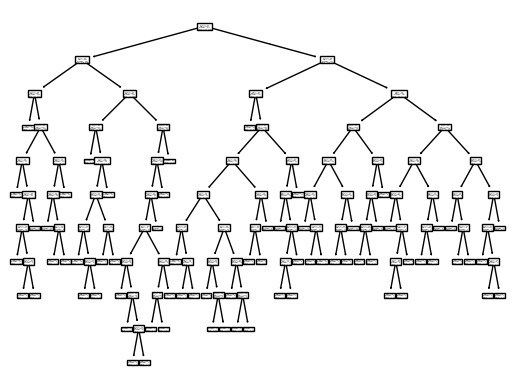

In [25]:
from sklearn import tree as t
t.plot_tree(
    decision_tree=pipe["tree"]#,feature_names=X_train.columns.to_list()
    #,filled=True
    #, proportion=True
)

In [26]:
tree.classes_

array(['negative', 'positive'], dtype=object)

In [27]:
print(tree_to_code(feature_names=ohe.get_feature_names_out(), tree=tree))

def tree(V1_b,V1_o,V1_x,V2_b,V2_o,V2_x,V3_b,V3_o,V3_x,V4_b,V4_o,V4_x,V5_b,V5_o,V5_x,V6_b,V6_o,V6_x,V7_b,V7_o,V7_x,V8_b,V8_o,V8_x,V9_b,V9_o,V9_x):
  if V5_o <= 0.5:
    if V1_o <= 0.5:
      if V9_o <= 0.5:
        return [[0. 1.]]
      else:  # if V9_o > 0.5
        if V7_o <= 0.5:
          if V3_o <= 0.5:
            return [[0. 1.]]
          else:  # if V3_o > 0.5
            if V6_o <= 0.5:
              if V4_o <= 0.5:
                return [[0. 1.]]
              else:  # if V4_o > 0.5
                if V7_x <= 0.5:
                  return [[0. 1.]]
                else:  # if V7_x > 0.5
                  return [[1. 0.]]
            else:  # if V6_o > 0.5
              return [[1. 0.]]
        else:  # if V7_o > 0.5
          if V8_o <= 0.5:
            if V6_o <= 0.5:
              return [[0. 1.]]
            else:  # if V6_o > 0.5
              if V3_o <= 0.5:
                return [[0. 1.]]
              else:  # if V3_o > 0.5
                return [[1. 0.]]
         

### Cross validation

In [28]:
classification_metrics(X=X_train, y=y_train, estimator=pipe)

ROC media: 0.88, desviación estándar: 0.03924342083092203


In [29]:
pipe.score(X_test, y_test)

0.9340277777777778

### Hyperparametrization

In [30]:
#DecisionTreeClassifier?

In [31]:
tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [32]:
param_dist = {"tree__max_depth": range(1, 5),
              "tree__max_features": ["auto", "sqrt", "log2"],
              "tree__min_samples_leaf": [x/100 for x in range(5, 51, 1)] + [x for x in range(1, 21)], 
              "tree__criterion": ["gini", "entropy"],
              "tree__splitter": ["best", "random"],
              "tree__class_weight": ["balanced", None]}

In [33]:
search = GridSearchCV(param_grid=param_dist, cv=4, n_jobs=-1, scoring="roc_auc", estimator=pipe, verbose=5,)

In [34]:
%%time
search.fit(X_train, y_train)

Fitting 4 folds for each of 6336 candidates, totalling 25344 fits
[CV 3/4] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=1, tree__max_features=auto, tree__min_samples_leaf=0.05, tree__splitter=best;, score=nan total time=   0.0s
[CV 4/4] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=1, tree__max_features=auto, tree__min_samples_leaf=0.05, tree__splitter=best;, score=nan total time=   0.0s
[CV 2/4] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=1, tree__max_features=auto, tree__min_samples_leaf=0.05, tree__splitter=best;, score=nan total time=   0.0s
[CV 2/4] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=1, tree__max_features=auto, tree__min_samples_leaf=0.05, tree__splitter=random;, score=nan total time=   0.0s
[CV 3/4] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=1, tree__max_features=auto, tree__min_samples_leaf=0.05, tree__splitter=random;, score=nan total tim

/Users/gblasd/Documents/DataScience/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8448 fits failed out of a total of 25344.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4261 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gblasd/Documents/DataScience/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gblasd/Documents/DataScience/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/gblasd/Docume

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('encoder',
                                        OneHotEncoder(sparse_output=False)),
                                       ('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__class_weight': ['balanced', None],
                         'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': range(1, 5),
                         'tree__max_features': ['auto', 'sqrt', 'log2'],
                         'tree__min_samples_leaf': [0.05, 0.06, 0.07, 0.08,
                                                    0.09, 0.1, 0.11, 0.12, 0.13,
                                                    0.14, 0.15, 0.16, 0.17,
                                                    0.18, 0.19, 0.2, 0.21, 0.22,
                                                    0.23, 0.24, 0.25, 0.26,
                                                    0.27, 0.28, 0.29, 0.3, 0.31,
                                                    0.32, 0.33, 0.34, ...],
                         'tree__splitter': ['best', 'random']},
             scoring='roc_auc', verbose=5)

In [35]:
search.best_estimator_

Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False)),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        max_features='sqrt', min_samples_leaf=4,
                                        splitter='random'))])

In [36]:
search.score(X_test, y_test)

np.float64(0.7156244770457968)

In [37]:
search.best_score_

np.float64(0.8016645600326847)

### Model preservation

In [38]:
path_out_models = '/Users/gblasd/Documents/DataScience/02_SupervisedLearning/models/'

In [39]:
pd.to_pickle(pipe, path_out_models + "dt_tictactoe.pickle")

In [40]:
n_pipe = pd.read_pickle(path_out_models + "dt_tictactoe.pickle")

In [41]:
n_pipe

Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False)),
                ('tree', DecisionTreeClassifier())])

In [42]:
X.head()

V1 V2 V3 V4 V5 V6 V7 V8 V9
0  x  x  x  x  o  o  x  o  o
1  x  x  x  x  o  o  o  x  o
2  x  x  x  x  o  o  o  o  x
3  x  x  x  x  o  o  o  b  b
4  x  x  x  x  o  o  b  o  b

In [43]:
X['proba']=pipe.predict_proba(X)[:,0]

In [44]:
X.sample(5)

V1 V2 V3 V4 V5 V6 V7 V8 V9  proba
251  x  b  o  x  o  b  x  x  o    0.0
558  b  o  x  b  o  x  b  b  x    0.0
18   x  x  x  o  x  b  o  o  b    0.0
775  o  x  o  x  o  x  x  b  o    1.0
911  b  x  b  o  o  o  x  b  x    1.0

In [45]:
X_test.head()

V1 V2 V3 V4 V5 V6 V7 V8 V9
457  o  b  x  b  b  x  b  o  x
848  o  o  b  x  o  x  x  o  x
74   x  x  x  b  b  o  b  b  o
252  x  b  o  x  o  b  x  o  x
23   x  x  x  o  o  x  o  o  x

In [46]:
X_2 = X[X_test.columns].copy()

In [47]:
X_2.tail()

V1 V2 V3 V4 V5 V6 V7 V8 V9
953  o  x  x  x  o  o  o  x  x
954  o  x  o  x  x  o  x  o  x
955  o  x  o  x  o  x  x  o  x
956  o  x  o  o  x  x  x  o  x
957  o  o  x  x  x  o  o  x  x

In [48]:
y.sample(10)

909    negative
222    positive
674    negative
82     positive
235    positive
214    positive
905    negative
79     positive
87     positive
751    negative
Name: V10, dtype: object

In [49]:
#La Probabilidad de 1, dice que va a ganar el X
n_pipe.predict_proba(X_2)#[:,0]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(958, 2))

In [50]:
n_pipe.predict(X_2)

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positi

In [51]:
X['proba'].value_counts(1)

proba
0.0    0.660752
1.0    0.339248
Name: proportion, dtype: float64

In [52]:
X.to_csv('tree_data.csv')